# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resized-2015-2019-blindness-detection-images', 'pretrained-pytorch-models', 'aptos2019-blindness-detection', 'fastai-pretrained-models']


In [2]:
import fastai
from fastai.vision import *
fastai.__version__

'1.0.54'

In [3]:
from torch.nn import CrossEntropyLoss

# Copy Pretrained Weights to Where Pytorch Will Look

In [4]:
# copy pretrained weights for resnet50 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp /kaggle/input/fastai-pretrained-models/* /tmp/.cache/torch/checkpoints/
!ls /tmp/.cache/torch/checkpoints/

densenet121-a639ec97.pth  resnet50-19c8e357.pth
densenet169-b2777c0a.pth  squeezenet1_0-a815701f.pth
densenet201-c1103571.pth  squeezenet1_1-f364aa15.pth
resnet101-5d3b4d8f.pth	  vgg16_bn-6c64b313.pth


# Data Loading

## Read The CSVs

In [5]:
!ls -1 ../input/resized-2015-2019-blindness-detection-images/labels/

testImages19.csv
testLabels15.csv
trainLabels15.csv
trainLabels19.csv


In [6]:
train_label_15 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')

In [7]:
train_label_19 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv')

In [8]:
test_label_15 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv')

In [9]:
train_label_15.level.value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [10]:
value_counts = np.array(train_label_15.level.value_counts(sort=False), dtype=np.float32)

In [11]:
value_counts

array([25810.,  2443.,  5292.,   873.,   708.], dtype=float32)

In [12]:
train_label_15.columns

Index(['image', 'level'], dtype='object')

In [13]:
train_label_19.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [14]:
train_label_19.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [15]:
test_label_15.level.value_counts()

0    39533
2     7861
1     3762
3     1214
4     1206
Name: level, dtype: int64

In [16]:
test_label_15.columns

Index(['image', 'level', 'Usage'], dtype='object')

## Load Data

In [17]:
import glob
import cv2
import numpy as np

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

In [18]:
class APTOSImageList(ImageList):
    def open(self, fn:PathOrStr) -> Image:
        img = circle_crop(str(fn))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        return Image(px=pil2tensor(img, np.float32))

In [19]:
path = Path("/kaggle/input/resized-2015-2019-blindness-detection-images")
src = (
    APTOSImageList.from_folder(path, presort=True, recurse=True)
        .filter_by_func(lambda item: item.parts[-2] != "resized test 19")
        .filter_by_func(lambda item: item.parts[-2] != "resized test 15")
        #.filter_by_func(lambda item: item.parts[-2] != "resized train 15")
        #.split_by_valid_func(lambda item: item.parts[-2] == "resized train 19")
        .split_by_rand_pct(0.1, 42)
        #.split_subsets(0.01, 0.01, 42)
    )
src

ItemLists;

Train: APTOSImageList (34910 items)
Image (3, 1017, 1017),Image (3, 1018, 1019),Image (3, 1023, 1023),Image (3, 1024, 1024),Image (3, 817, 817)
Path: /kaggle/input/resized-2015-2019-blindness-detection-images;

Valid: APTOSImageList (3878 items)
Image (3, 1016, 1017),Image (3, 761, 765),Image (3, 851, 851),Image (3, 981, 981),Image (3, 1016, 1017)
Path: /kaggle/input/resized-2015-2019-blindness-detection-images;

Test: None

## Label the Data

In [20]:
train_label_15_dict = dict(zip(list(train_label_15.image), list(train_label_15.level)))

In [21]:
train_label_19_dict = dict(zip(list(train_label_19.id_code), list(train_label_19.diagnosis)))

In [22]:
test_label_15_dict = dict(zip(list(test_label_15.image), list(test_label_15.level)))

In [23]:
def label_func(item):
    if item.parts[-2] == "resized train 15":
        return train_label_15_dict[item.stem]
    elif item.parts[-2] == "resized test 15":
        return test_label_15_dict[item.stem]
    elif item.parts[-2] == "resized train 19":
        return train_label_19_dict[item.stem]
    else:
        assert(False)

In [24]:
src = src.label_from_func(label_func)

## Transformations

In [25]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True, 
                      max_rotate=360., 
                      max_zoom=1.0,
                      max_warp=None, 
                      max_lighting=0.2,
                      p_affine=0.,
                      p_lighting=0.,
                     )

## Create Databunch

In [26]:
data = (
    src.transform(tfms,size=224)
    .databunch(bs=64)
    .normalize()
)
data

ImageDataBunch;

Train: LabelList (34910 items)
x: APTOSImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /kaggle/input/resized-2015-2019-blindness-detection-images;

Valid: LabelList (3878 items)
x: APTOSImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,2,0
Path: /kaggle/input/resized-2015-2019-blindness-detection-images;

Test: None

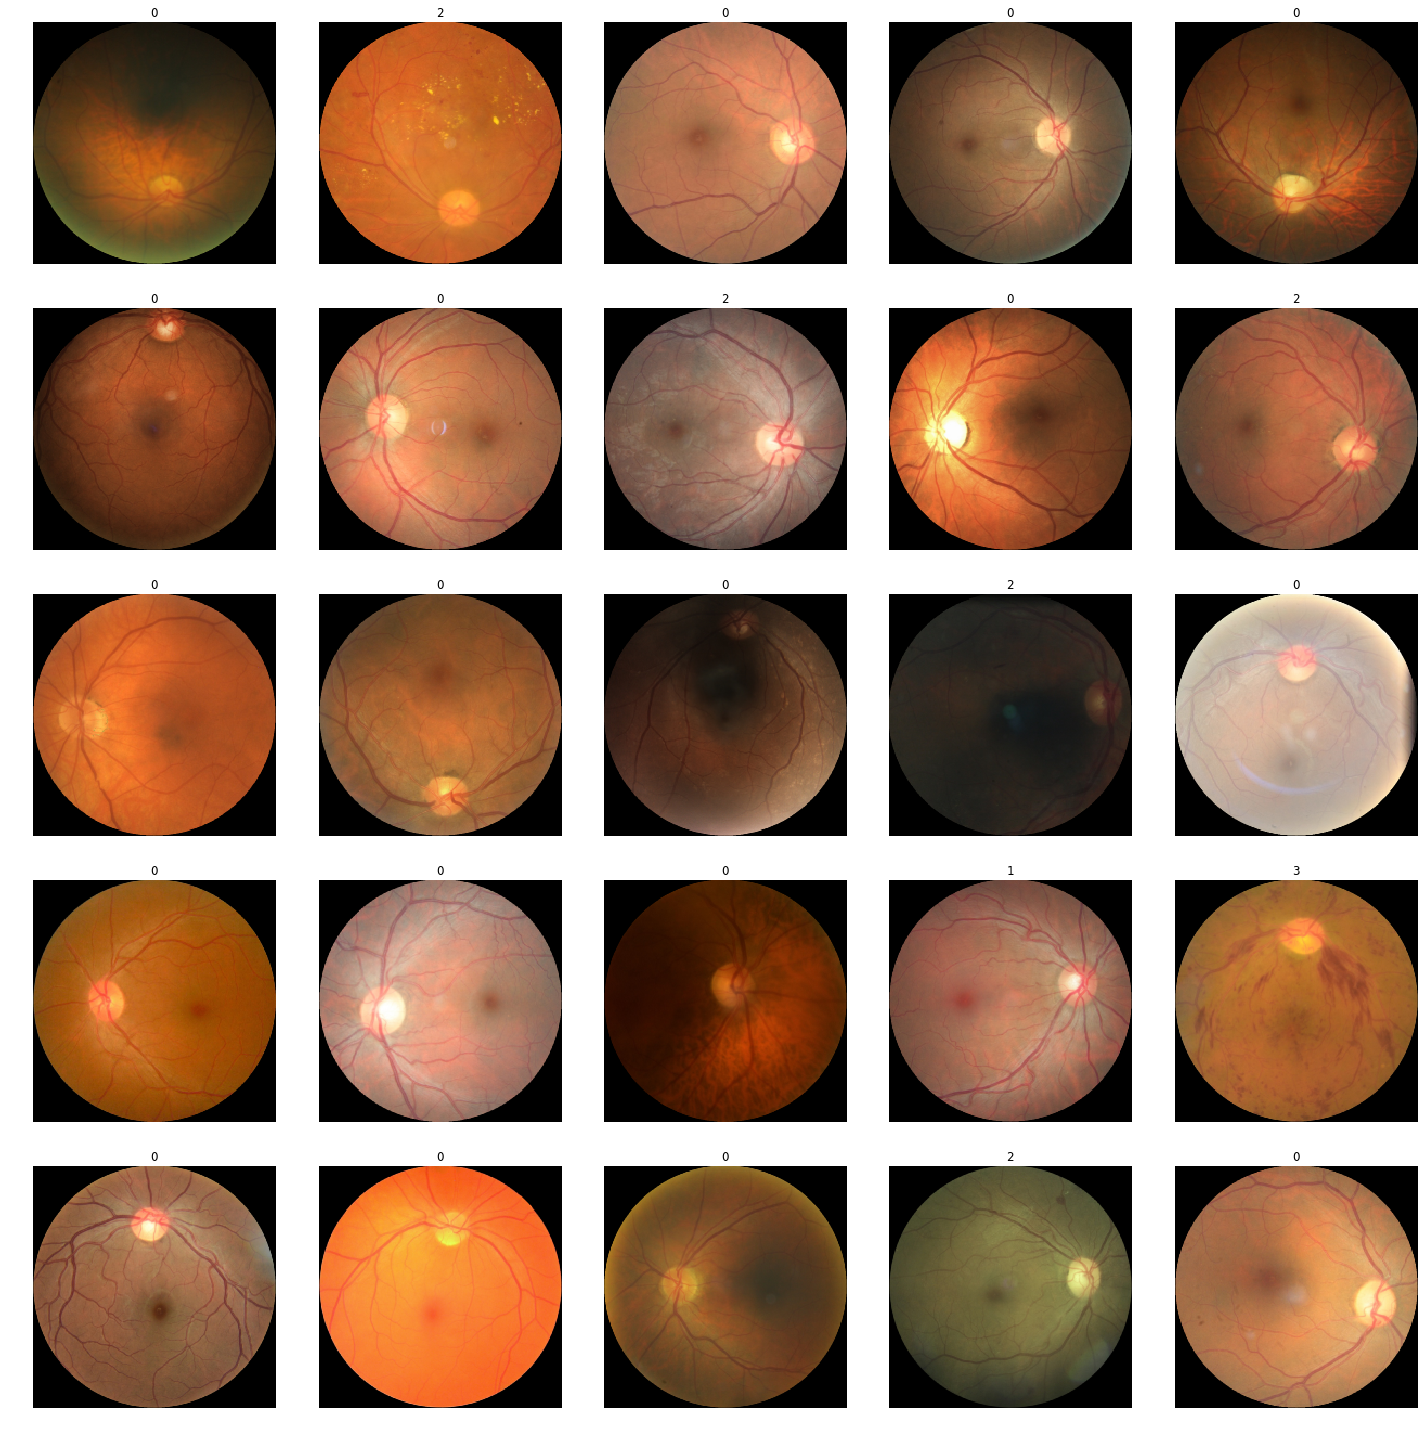

In [27]:
data.show_batch()

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

    
def roc_score(inp, target):
    _, indices = inp.max(1)
    return torch.Tensor([roc_auc_score(target, indices)])[0]

In [29]:
kappa = KappaScore()
kappa.weights = "quadratic"
precision = Precision(average="macro")
recall = Recall(average="macro")
loss_func = FocalLoss(gamma=5.)

In [30]:
learn = cnn_learner(data, models.densenet201 ,metrics=[accuracy, error_rate, kappa, precision, recall],
                    loss_func=loss_func,
                    model_dir='/kaggle/working', pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 1.00E-02


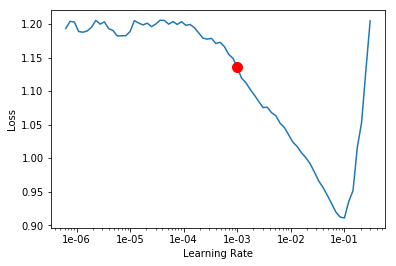

In [31]:
# Find a good learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
lr = 2.29E-02
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,kappa_score,precision,recall,time
0,0.171352,0.158402,0.752450,0.247550,0.602456,0.382295,0.387721,34:42
1,0.156809,0.200193,0.764311,0.235688,0.593544,0.564667,0.417452,33:27
2,0.162023,0.201297,0.760444,0.239556,0.592972,0.524186,0.349156,33:33
3,0.156574,0.378191,0.767148,0.232852,0.565611,0.462746,0.337700,34:01
4,0.146818,0.131872,0.779526,0.220474,0.693222,0.346754,0.405339,36:02
5,0.134882,0.168456,0.797576,0.202424,0.657576,0.620606,0.416102,36:49


In [33]:
learn.save('stage-01')

In [34]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

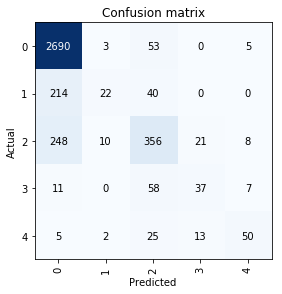

In [35]:
interp.plot_confusion_matrix()

In [36]:
# learn.unfreeze()

In [37]:
# # Find a good learning rate
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [38]:
# lr = 4.8E-06
# learn.fit_one_cycle(10, slice(lr))

In [39]:
# preds,y,losses = learn.get_preds(with_loss=True)
# interp = ClassificationInterpretation(learn, preds, y, losses)

In [40]:
# interp.plot_confusion_matrix()

In [41]:
# learn.save('stage-02')

# Predictions

In [42]:
# test_df = pd.read_csv(PATH/'test.csv')
# test_df.head()
PATH = Path('../input/aptos2019-blindness-detection')
sample_df = pd.read_csv(PATH/'sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [43]:
learn.data.add_test(ImageList.from_df(sample_df,PATH,folder='test_images',suffix='.png'))

In [44]:
preds,y = learn.get_preds(DatasetType.Test)

In [45]:
sample_df.diagnosis = preds.argmax(1)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [46]:
sample_df.to_csv('submission.csv',index=False)